In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
net = NeuralNetwork()

/home/user/anaconda3/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
if torch.cuda.is_available():
    net = net.cuda()

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize(512), transforms.CenterCrop(511), transforms.RandomRotation(30),transforms.RandomHorizontalFlip(), transforms.transforms.ToTensor()]) 

In [7]:
def UploadData(path, train):
    #set up transforms for train and test datasets
    train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize(512), transforms.CenterCrop(511), transforms.RandomRotation(30),transforms.RandomHorizontalFlip(), transforms.transforms.ToTensor()]) 
    valid_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize(512), transforms.CenterCrop(511), transforms.transforms.ToTensor()]) 
    #test_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize(512), transforms.CenterCrop(511), transforms.ToTensor()])
    
    #set up datasets from Image Folders
    train_dataset = datasets.ImageFolder(path + '/train', transform=train_transforms)
    valid_dataset = datasets.ImageFolder(path + '/validation', transform=valid_transforms)
    #test_dataset = datasets.ImageFolder(path + '/test', transform=test_transforms)

    #set up dataloaders with batch size of 32
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
    #testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
  
    return trainloader, validloader #, testloader

In [8]:
trainloader, validloader = UploadData("/home/user/research/CXR_Covid-19_Challenge", True) #, testloader

In [9]:
trainloader.dataset.class_to_idx

{'covid': 0, 'normal': 1, 'pneumonia': 2}

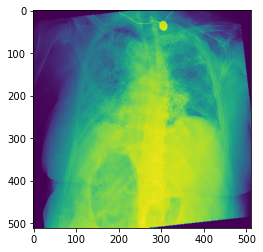

In [10]:
#Show Image in Train set
train_images, labels = next(iter(trainloader))
trainImg = train_images[0].numpy()
plt.imshow(trainImg[0])

In [11]:
import time
  
def convert(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [12]:
from tqdm import tqdm

In [13]:
from playsound import playsound

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [14]:
min_valid_loss = np.inf

In [15]:
loss_train_list = []
loss_valid_list = []
acc_train_list = []
acc_valid_list = []
epochs = 100
total_time = time.time()
for e in range(epochs):
    start_time=time.time()
    train_loss = 0.0
    right_train = 0
    total_train = 0
    for data, labels in tqdm(trainloader):
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = net(data)
        _, predicted = torch.max(target, 1)
        # Find the Loss
        loss = criterion(target,labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        correct = (predicted == labels).float().sum()
        right_train+=correct.float()
        total_train+=len(predicted)
     
    valid_loss = 0.0
    right_valid = 0
    total_valid = 0
    net.eval()     # Optional when not using Model Specific layer
    for data, labels in (validloader):
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Forward Pass
        target = net(data)
        _, predicted = torch.max(target, 1)
        # Find the Loss
        loss = criterion(target,labels)
        # Calculate Loss
        valid_loss += loss.item()
        correct = (predicted == labels).float().sum()
        right_valid+=correct.float()
        total_valid+=len(predicted)
    ftloss = train_loss / len(trainloader)
    fvloss = valid_loss / len(validloader)
    ftacc = float(right_train*100/total_train)
    fvacc = float(right_valid*100/total_valid)
    loss_train_list.append(ftloss)
    loss_valid_list.append(fvloss)
    acc_train_list.append(ftacc)
    acc_valid_list.append(fvacc)
    print('Epoch',e+1, '\tTraining Loss:',ftloss,'\tValidation Loss:',fvloss,"\t time:",convert(time.time()-start_time))
    print("Train Accuracy :",ftacc,"\tValidation Accuracy :",fvacc)
    if min_valid_loss > valid_loss:
        print("Validation Loss Decreased(",min_valid_loss,"--->",valid_loss,") \t Saving The Model")
        min_valid_loss = valid_loss
         
        # Saving State Dict
        torch.save(net.state_dict(), '/home/user/research/CNN/cnn_model_new.pth')
print("total time : ",convert(time.time()-total_time))
playsound('/home/user/research/audio')

  0%|          | 0/562 [00:00<?, ?it/s]/home/user/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 562/562 [05:42<00:00,  1.64it/s]


Epoch 1 	Training Loss: 0.9029228049877276 	Validation Loss: 0.8944440715842776 	 time: 00:06:31
Train Accuracy : 57.63447952270508 	Validation Accuracy : 59.32400894165039
Validation Loss Decreased( inf ---> 96.59995973110199 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 2 	Training Loss: 0.8856767352365514 	Validation Loss: 0.9128290994299783 	 time: 00:06:48
Train Accuracy : 58.620113372802734 	Validation Accuracy : 56.75990676879883


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 3 	Training Loss: 0.8471003622346925 	Validation Loss: 0.9120684911807379 	 time: 00:06:52
Train Accuracy : 61.18721389770508 	Validation Accuracy : 57.808860778808594


100%|██████████| 562/562 [05:56<00:00,  1.58it/s]


Epoch 4 	Training Loss: 0.8119809344888158 	Validation Loss: 0.8293078966714718 	 time: 00:06:45
Train Accuracy : 63.35337829589844 	Validation Accuracy : 62.150352478027344
Validation Loss Decreased( 96.59995973110199 ---> 89.56525284051895 ) 	 Saving The Model


100%|██████████| 562/562 [05:52<00:00,  1.60it/s]


Epoch 5 	Training Loss: 0.7705369327628315 	Validation Loss: 0.8124735769298341 	 time: 00:06:39
Train Accuracy : 66.14321899414062 	Validation Accuracy : 63.05361557006836
Validation Loss Decreased( 89.56525284051895 ---> 87.74714630842209 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 6 	Training Loss: 0.741771535623116 	Validation Loss: 0.8236339531011052 	 time: 00:06:49
Train Accuracy : 68.24813079833984 	Validation Accuracy : 64.16084289550781


100%|██████████| 562/562 [05:51<00:00,  1.60it/s]


Epoch 7 	Training Loss: 0.7327183050723263 	Validation Loss: 0.7604639452916605 	 time: 00:06:43
Train Accuracy : 68.82726287841797 	Validation Accuracy : 67.83216857910156
Validation Loss Decreased( 87.74714630842209 ---> 82.13010609149933 ) 	 Saving The Model


100%|██████████| 562/562 [05:56<00:00,  1.58it/s]


Epoch 8 	Training Loss: 0.7158604902198731 	Validation Loss: 0.7314019556398745 	 time: 00:06:48
Train Accuracy : 69.6681137084961 	Validation Accuracy : 69.17249298095703
Validation Loss Decreased( 82.13010609149933 ---> 78.99141120910645 ) 	 Saving The Model


100%|██████████| 562/562 [06:00<00:00,  1.56it/s]


Epoch 9 	Training Loss: 0.6923646768323043 	Validation Loss: 0.7229070735198481 	 time: 00:06:45
Train Accuracy : 70.92103576660156 	Validation Accuracy : 68.88111877441406
Validation Loss Decreased( 78.99141120910645 ---> 78.07396394014359 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 10 	Training Loss: 0.6785714580707278 	Validation Loss: 0.7380137079291873 	 time: 00:06:11
Train Accuracy : 71.2718505859375 	Validation Accuracy : 70.39627075195312


100%|██████████| 562/562 [05:33<00:00,  1.68it/s]


Epoch 11 	Training Loss: 0.676262518105982 	Validation Loss: 0.676862828709461 	 time: 00:06:17
Train Accuracy : 71.97905731201172 	Validation Accuracy : 72.17366027832031
Validation Loss Decreased( 78.07396394014359 ---> 73.1011855006218 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 12 	Training Loss: 0.6698277538039082 	Validation Loss: 0.8797201442497747 	 time: 00:06:22
Train Accuracy : 72.0180435180664 	Validation Accuracy : 60.75175094604492


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 13 	Training Loss: 0.6627295674272279 	Validation Loss: 0.7323361265438574 	 time: 00:06:38
Train Accuracy : 72.8477554321289 	Validation Accuracy : 69.23077392578125


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 14 	Training Loss: 0.6527160725347512 	Validation Loss: 0.7401043899633266 	 time: 00:06:54
Train Accuracy : 73.28766632080078 	Validation Accuracy : 69.66783142089844


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 15 	Training Loss: 0.6403792584281799 	Validation Loss: 0.6886368589820685 	 time: 00:06:36
Train Accuracy : 73.85565948486328 	Validation Accuracy : 71.47435760498047


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 16 	Training Loss: 0.6318943491769007 	Validation Loss: 0.7204805187605046 	 time: 00:06:50
Train Accuracy : 74.20091247558594 	Validation Accuracy : 70.54196166992188


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 17 	Training Loss: 0.6226259863461464 	Validation Loss: 0.7040614678903863 	 time: 00:06:53
Train Accuracy : 74.68537139892578 	Validation Accuracy : 71.99883270263672


100%|██████████| 562/562 [06:20<00:00,  1.48it/s]


Epoch 18 	Training Loss: 0.6235986035383468 	Validation Loss: 0.6673177524849221 	 time: 00:07:15
Train Accuracy : 74.70207977294922 	Validation Accuracy : 72.7272720336914
Validation Loss Decreased( 73.1011855006218 ---> 72.07031726837158 ) 	 Saving The Model


100%|██████████| 562/562 [06:12<00:00,  1.51it/s]


Epoch 19 	Training Loss: 0.603867971520619 	Validation Loss: 0.6556077698866526 	 time: 00:07:03
Train Accuracy : 75.72669219970703 	Validation Accuracy : 73.42657470703125
Validation Loss Decreased( 72.07031726837158 ---> 70.80563914775848 ) 	 Saving The Model


100%|██████████| 562/562 [06:02<00:00,  1.55it/s]


Epoch 20 	Training Loss: 0.5996408582370052 	Validation Loss: 0.6324033361894114 	 time: 00:06:51
Train Accuracy : 75.86033630371094 	Validation Accuracy : 75.29137420654297
Validation Loss Decreased( 70.80563914775848 ---> 68.29956030845642 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 21 	Training Loss: 0.5935023639921192 	Validation Loss: 0.6485145138921561 	 time: 00:07:34
Train Accuracy : 76.26127624511719 	Validation Accuracy : 73.31002807617188


100%|██████████| 562/562 [06:00<00:00,  1.56it/s]


Epoch 22 	Training Loss: 0.5775027493830254 	Validation Loss: 0.6033395292858282 	 time: 00:06:52
Train Accuracy : 76.95177459716797 	Validation Accuracy : 76.45687866210938
Validation Loss Decreased( 68.29956030845642 ---> 65.16066916286945 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 23 	Training Loss: 0.5658614781032253 	Validation Loss: 0.6150209567061177 	 time: 00:06:55
Train Accuracy : 77.76478576660156 	Validation Accuracy : 75.81584930419922


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 24 	Training Loss: 0.5587423649546939 	Validation Loss: 0.6809103475124748 	 time: 00:06:59
Train Accuracy : 78.14344024658203 	Validation Accuracy : 72.98950958251953


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 25 	Training Loss: 0.5468475903745648 	Validation Loss: 0.6453374088914307 	 time: 00:06:46
Train Accuracy : 78.58335876464844 	Validation Accuracy : 74.09674072265625


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 26 	Training Loss: 0.5547165346209265 	Validation Loss: 0.6095044458353961 	 time: 00:06:27
Train Accuracy : 78.1768569946289 	Validation Accuracy : 75.64102935791016


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 27 	Training Loss: 0.5380605110812442 	Validation Loss: 0.6276791799399588 	 time: 00:06:28
Train Accuracy : 79.0733871459961 	Validation Accuracy : 75.14569091796875


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 28 	Training Loss: 0.5361319128887934 	Validation Loss: 0.6042463669070491 	 time: 00:06:41
Train Accuracy : 79.27942657470703 	Validation Accuracy : 76.42774200439453


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 29 	Training Loss: 0.5231574617883065 	Validation Loss: 0.6972870423837945 	 time: 00:06:40
Train Accuracy : 79.44648742675781 	Validation Accuracy : 71.32867431640625


100%|██████████| 562/562 [05:50<00:00,  1.60it/s]


Epoch 30 	Training Loss: 0.538012137139395 	Validation Loss: 0.5839059344596333 	 time: 00:06:38
Train Accuracy : 78.90633392333984 	Validation Accuracy : 77.41841888427734
Validation Loss Decreased( 65.16066916286945 ---> 63.061840921640396 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 31 	Training Loss: 0.5200198032624781 	Validation Loss: 0.6576835181978014 	 time: 00:06:31
Train Accuracy : 79.82514190673828 	Validation Accuracy : 73.89277648925781


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 32 	Training Loss: 0.5140829452469255 	Validation Loss: 0.7197631487139949 	 time: 00:06:23
Train Accuracy : 79.9476547241211 	Validation Accuracy : 70.97901916503906


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 33 	Training Loss: 0.5107236489706617 	Validation Loss: 0.6104853100798748 	 time: 00:06:35
Train Accuracy : 80.11470794677734 	Validation Accuracy : 75.58275604248047


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 34 	Training Loss: 0.4948225080489688 	Validation Loss: 0.6035054706864886 	 time: 00:06:28
Train Accuracy : 81.0446548461914 	Validation Accuracy : 74.6212158203125


100%|██████████| 562/562 [05:42<00:00,  1.64it/s]


Epoch 35 	Training Loss: 0.48714314199639386 	Validation Loss: 0.5258092273164678 	 time: 00:06:34
Train Accuracy : 81.13375091552734 	Validation Accuracy : 79.22494506835938
Validation Loss Decreased( 63.061840921640396 ---> 56.78739655017853 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 36 	Training Loss: 0.48779024150607 	Validation Loss: 0.594145884944333 	 time: 00:06:37
Train Accuracy : 81.06136322021484 	Validation Accuracy : 76.36946868896484


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 37 	Training Loss: 0.5009896781733028 	Validation Loss: 0.5729684631029764 	 time: 00:06:37
Train Accuracy : 80.40984344482422 	Validation Accuracy : 76.95221710205078


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 38 	Training Loss: 0.4772794395685196 	Validation Loss: 0.5359699957900577 	 time: 00:06:39
Train Accuracy : 81.89664459228516 	Validation Accuracy : 78.8170166015625


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 39 	Training Loss: 0.48806979586751437 	Validation Loss: 0.5759746941427389 	 time: 00:07:01
Train Accuracy : 81.21171569824219 	Validation Accuracy : 77.36013793945312


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 40 	Training Loss: 0.4783191208154281 	Validation Loss: 0.5715127614913164 	 time: 00:06:42
Train Accuracy : 81.46229553222656 	Validation Accuracy : 77.53496551513672


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 41 	Training Loss: 0.4732402967308976 	Validation Loss: 0.5820767724955523 	 time: 00:06:55
Train Accuracy : 81.56253051757812 	Validation Accuracy : 76.63170623779297


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 42 	Training Loss: 0.4650362822694498 	Validation Loss: 0.6060397622210009 	 time: 00:06:59
Train Accuracy : 82.19178009033203 	Validation Accuracy : 75.08741760253906


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 43 	Training Loss: 0.4605097197977249 	Validation Loss: 0.5849179564112866 	 time: 00:06:47
Train Accuracy : 82.54259490966797 	Validation Accuracy : 77.47669219970703


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 44 	Training Loss: 0.45593101589599117 	Validation Loss: 0.5505736610955663 	 time: 00:06:58
Train Accuracy : 82.46463775634766 	Validation Accuracy : 79.77855682373047


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 45 	Training Loss: 0.4556735833424054 	Validation Loss: 0.6444224847687615 	 time: 00:06:49
Train Accuracy : 82.25859832763672 	Validation Accuracy : 75.72843933105469


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 46 	Training Loss: 0.4516571824873045 	Validation Loss: 0.594107069351055 	 time: 00:07:16
Train Accuracy : 82.7430648803711 	Validation Accuracy : 77.01049041748047


100%|██████████| 562/562 [06:01<00:00,  1.56it/s]


Epoch 47 	Training Loss: 0.44326862740559086 	Validation Loss: 0.5104974389628127 	 time: 00:06:55
Train Accuracy : 82.88784790039062 	Validation Accuracy : 79.05011749267578
Validation Loss Decreased( 56.78739655017853 ---> 55.13372340798378 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 48 	Training Loss: 0.44160879766601685 	Validation Loss: 0.5294558451407485 	 time: 00:07:05
Train Accuracy : 83.23309326171875 	Validation Accuracy : 80.12820434570312


100%|██████████| 562/562 [05:58<00:00,  1.57it/s]


Epoch 49 	Training Loss: 0.42966303054336125 	Validation Loss: 0.5046062285977381 	 time: 00:06:45
Train Accuracy : 83.60618591308594 	Validation Accuracy : 80.24475860595703
Validation Loss Decreased( 55.13372340798378 ---> 54.49747268855572 ) 	 Saving The Model


100%|██████████| 562/562 [05:50<00:00,  1.60it/s]


Epoch 50 	Training Loss: 0.4365461183135196 	Validation Loss: 0.49573717942392387 	 time: 00:06:46
Train Accuracy : 83.43356323242188 	Validation Accuracy : 80.88578033447266
Validation Loss Decreased( 54.49747268855572 ---> 53.539615377783775 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 51 	Training Loss: 0.4393774249799735 	Validation Loss: 0.542883567236088 	 time: 00:06:47
Train Accuracy : 83.1941146850586 	Validation Accuracy : 78.84615325927734


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 52 	Training Loss: 0.4241394173764885 	Validation Loss: 0.52265090384969 	 time: 00:07:04
Train Accuracy : 83.80108642578125 	Validation Accuracy : 79.13752746582031


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 53 	Training Loss: 0.41579384702088784 	Validation Loss: 0.5224103926232567 	 time: 00:07:17
Train Accuracy : 84.31896209716797 	Validation Accuracy : 80.7109603881836


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 54 	Training Loss: 0.4219729055607446 	Validation Loss: 0.5424923496665778 	 time: 00:06:52
Train Accuracy : 83.9570083618164 	Validation Accuracy : 79.16667175292969


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 55 	Training Loss: 0.4344543345484657 	Validation Loss: 0.5544744128430331 	 time: 00:06:51
Train Accuracy : 83.56163787841797 	Validation Accuracy : 79.4871826171875


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 56 	Training Loss: 0.42892047239208986 	Validation Loss: 0.6630421954172628 	 time: 00:06:40
Train Accuracy : 83.89018249511719 	Validation Accuracy : 75.75757598876953


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 57 	Training Loss: 0.4104134016189711 	Validation Loss: 0.5150271084297586 	 time: 00:06:54
Train Accuracy : 84.22429656982422 	Validation Accuracy : 79.63286590576172


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 58 	Training Loss: 0.3950271703488462 	Validation Loss: 0.5091825410447739 	 time: 00:06:41
Train Accuracy : 85.00389862060547 	Validation Accuracy : 80.5361328125


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 59 	Training Loss: 0.4049163169469486 	Validation Loss: 0.5659814819141671 	 time: 00:06:49
Train Accuracy : 84.37464904785156 	Validation Accuracy : 78.11771392822266


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 60 	Training Loss: 0.4085990673467994 	Validation Loss: 0.6131980065946225 	 time: 00:06:57
Train Accuracy : 84.45260620117188 	Validation Accuracy : 77.91375732421875


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 61 	Training Loss: 0.4266822505543453 	Validation Loss: 0.5203534404712694 	 time: 00:06:58
Train Accuracy : 83.90689086914062 	Validation Accuracy : 80.97319793701172


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 62 	Training Loss: 0.4057566263842201 	Validation Loss: 0.5222419394111192 	 time: 00:06:46
Train Accuracy : 84.88695526123047 	Validation Accuracy : 79.42890930175781


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 63 	Training Loss: 0.3956257048000008 	Validation Loss: 0.5357174716751885 	 time: 00:06:39
Train Accuracy : 85.03173828125 	Validation Accuracy : 79.72028350830078


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 64 	Training Loss: 0.3930586477827771 	Validation Loss: 0.5213135158022245 	 time: 00:06:54
Train Accuracy : 85.09856414794922 	Validation Accuracy : 79.72028350830078


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 65 	Training Loss: 0.38868296031717514 	Validation Loss: 0.5845458168122504 	 time: 00:06:48
Train Accuracy : 85.43824005126953 	Validation Accuracy : 77.36013793945312


100%|██████████| 562/562 [06:00<00:00,  1.56it/s]


Epoch 66 	Training Loss: 0.3743342116103902 	Validation Loss: 0.47417158150562533 	 time: 00:06:50
Train Accuracy : 86.14544677734375 	Validation Accuracy : 82.2552490234375
Validation Loss Decreased( 53.539615377783775 ---> 51.210530802607536 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 67 	Training Loss: 0.3814578014309932 	Validation Loss: 0.6384360061751472 	 time: 00:06:56
Train Accuracy : 85.88929748535156 	Validation Accuracy : 77.85547637939453


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 68 	Training Loss: 0.3842689093348182 	Validation Loss: 0.48013403570210494 	 time: 00:06:49
Train Accuracy : 85.60530090332031 	Validation Accuracy : 82.51748657226562


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 69 	Training Loss: 0.37951515866874375 	Validation Loss: 0.5551777308185896 	 time: 00:06:48
Train Accuracy : 85.79463195800781 	Validation Accuracy : 78.52564239501953


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 70 	Training Loss: 0.37778037140855164 	Validation Loss: 0.6369037684743051 	 time: 00:06:53
Train Accuracy : 85.70553588867188 	Validation Accuracy : 76.8939437866211


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 71 	Training Loss: 0.3850887486929889 	Validation Loss: 0.5161193176000206 	 time: 00:06:50
Train Accuracy : 85.5997314453125 	Validation Accuracy : 80.76923370361328


100%|██████████| 562/562 [06:02<00:00,  1.55it/s]


Epoch 72 	Training Loss: 0.3706632720379431 	Validation Loss: 0.4723347807648005 	 time: 00:06:51
Train Accuracy : 86.20670318603516 	Validation Accuracy : 82.98368835449219
Validation Loss Decreased( 51.210530802607536 ---> 51.01215632259846 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 73 	Training Loss: 0.363397472170165 	Validation Loss: 0.5204819073831594 	 time: 00:06:58
Train Accuracy : 86.26239013671875 	Validation Accuracy : 79.45804595947266


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 74 	Training Loss: 0.35750560526109676 	Validation Loss: 0.4980683869647759 	 time: 00:06:51
Train Accuracy : 86.69673156738281 	Validation Accuracy : 81.81818389892578


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 75 	Training Loss: 0.35306707385171776 	Validation Loss: 0.5271965176970871 	 time: 00:06:49
Train Accuracy : 86.94731903076172 	Validation Accuracy : 80.59440612792969


100%|██████████| 562/562 [06:00<00:00,  1.56it/s]


Epoch 76 	Training Loss: 0.35285318319377523 	Validation Loss: 0.46226683879892033 	 time: 00:06:52
Train Accuracy : 86.84151458740234 	Validation Accuracy : 83.24592590332031
Validation Loss Decreased( 51.01215632259846 ---> 49.924818590283394 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 77 	Training Loss: 0.3440603395771514 	Validation Loss: 0.4683791854315334 	 time: 00:06:50
Train Accuracy : 87.11994171142578 	Validation Accuracy : 82.7505874633789


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 78 	Training Loss: 0.33785627478753544 	Validation Loss: 0.5578625021433389 	 time: 00:06:46
Train Accuracy : 87.38723754882812 	Validation Accuracy : 77.79720306396484


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 79 	Training Loss: 0.34567932541286606 	Validation Loss: 0.48196811063422096 	 time: 00:06:58
Train Accuracy : 86.9417495727539 	Validation Accuracy : 81.06060791015625


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 80 	Training Loss: 0.34494500493239677 	Validation Loss: 0.4852829767322099 	 time: 00:08:57
Train Accuracy : 87.29813385009766 	Validation Accuracy : 80.27389526367188


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 81 	Training Loss: 0.3418734817835254 	Validation Loss: 0.4769098451016126 	 time: 00:07:31
Train Accuracy : 87.08096313476562 	Validation Accuracy : 82.19696807861328


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 82 	Training Loss: 0.3200561340725931 	Validation Loss: 0.4822914483094657 	 time: 00:07:20
Train Accuracy : 88.06102752685547 	Validation Accuracy : 82.89627075195312


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 83 	Training Loss: 0.3378799657247881 	Validation Loss: 0.496175997649078 	 time: 00:06:56
Train Accuracy : 87.55429077148438 	Validation Accuracy : 81.87645721435547


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 84 	Training Loss: 0.32990650342797256 	Validation Loss: 0.4860944132562037 	 time: 00:07:12
Train Accuracy : 87.9552230834961 	Validation Accuracy : 82.37179565429688


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 85 	Training Loss: 0.33767457954002233 	Validation Loss: 0.5501075481513032 	 time: 00:06:56
Train Accuracy : 87.74362182617188 	Validation Accuracy : 80.3613052368164


100%|██████████| 562/562 [06:23<00:00,  1.47it/s]


Epoch 86 	Training Loss: 0.315956815653 	Validation Loss: 0.43915262694160145 	 time: 00:07:13
Train Accuracy : 88.2670669555664 	Validation Accuracy : 82.634033203125
Validation Loss Decreased( 49.924818590283394 ---> 47.428483709692955 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 87 	Training Loss: 0.3222351762999737 	Validation Loss: 0.5052717746821819 	 time: 00:07:00
Train Accuracy : 88.03875732421875 	Validation Accuracy : 82.43006896972656


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 88 	Training Loss: 0.32136212186589574 	Validation Loss: 0.48401865404513145 	 time: 00:06:59
Train Accuracy : 88.0777359008789 	Validation Accuracy : 83.47901916503906


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 89 	Training Loss: 0.3022051092098033 	Validation Loss: 0.46346047189500594 	 time: 00:07:19
Train Accuracy : 88.84062194824219 	Validation Accuracy : 83.88694763183594


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 90 	Training Loss: 0.30220048422544027 	Validation Loss: 0.5105993631123392 	 time: 00:07:06
Train Accuracy : 88.97427368164062 	Validation Accuracy : 83.24592590332031


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 91 	Training Loss: 0.3055765822171847 	Validation Loss: 0.5244620022950349 	 time: 00:07:02
Train Accuracy : 88.66799926757812 	Validation Accuracy : 82.95454406738281


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 92 	Training Loss: 0.30953261457065456 	Validation Loss: 1.0839747182197041 	 time: 00:06:56
Train Accuracy : 88.37286376953125 	Validation Accuracy : 74.56294250488281


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 93 	Training Loss: 0.3242695900840267 	Validation Loss: 0.45126490432907035 	 time: 00:07:07
Train Accuracy : 87.93852233886719 	Validation Accuracy : 83.07109832763672


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 94 	Training Loss: 0.30310345478886175 	Validation Loss: 0.47017240883023653 	 time: 00:07:16
Train Accuracy : 88.6401596069336 	Validation Accuracy : 82.634033203125


100%|██████████| 562/562 [06:07<00:00,  1.53it/s]


Epoch 95 	Training Loss: 0.29942518796148676 	Validation Loss: 0.4341367942591508 	 time: 00:06:59
Train Accuracy : 88.92972564697266 	Validation Accuracy : 84.38228607177734
Validation Loss Decreased( 47.428483709692955 ---> 46.88677377998829 ) 	 Saving The Model


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 96 	Training Loss: 0.30434063478667966 	Validation Loss: 0.46439169802599484 	 time: 00:07:05
Train Accuracy : 88.56776428222656 	Validation Accuracy : 80.85664367675781


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 97 	Training Loss: 0.3168919574058353 	Validation Loss: 0.6083490194545852 	 time: 00:07:21
Train Accuracy : 88.36730194091797 	Validation Accuracy : 78.05944061279297


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 98 	Training Loss: 0.29728707446454894 	Validation Loss: 0.4969119317829609 	 time: 00:06:58
Train Accuracy : 89.08007049560547 	Validation Accuracy : 82.83799743652344


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 99 	Training Loss: 0.28510440849480334 	Validation Loss: 0.5444494509310635 	 time: 00:07:10
Train Accuracy : 89.38077545166016 	Validation Accuracy : 81.00233459472656


100%|██████████| 562/562 [06:07<00:00,  1.53it/s]


Epoch 100 	Training Loss: 0.28271967525431535 	Validation Loss: 0.47462088207679765 	 time: 00:06:56
Train Accuracy : 89.64249420166016 	Validation Accuracy : 83.42074584960938
total time :  11:29:30


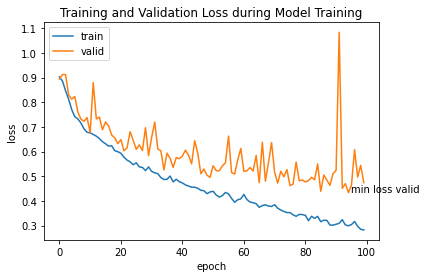

In [21]:
plt.plot(loss_train_list)
plt.plot(loss_valid_list)
plt.annotate("min loss valid",(95,min(loss_valid_list)))
plt.title('Training and Validation Loss during Model Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid','minimum'], loc='upper left')
plt.show()

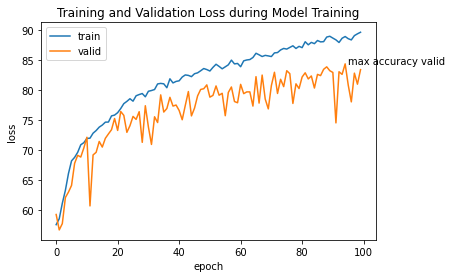

In [23]:
plt.plot(acc_train_list)
plt.plot(acc_valid_list)
plt.annotate("max accuracy valid",(95,max(acc_valid_list)))
plt.title('Training and Validation Loss during Model Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [24]:
f1 = open("/home/user/research/CNN/loss_train.txt","w")
f2 = open("/home/user/research/CNN/loss_valid.txt","w")
f3 = open("/home/user/research/CNN/acc_train.txt","w")
f4 = open("/home/user/research/CNN/acc_valid.txt","w")
for i in range(len(loss_train_list)):
    f1.write(str(loss_train_list[i]))
    f1.write(",")
    f2.write(str(loss_valid_list[i]))
    f2.write(",")
    f3.write(str(acc_train_list[i]))
    f3.write(",")
    f4.write(str(acc_valid_list[i]))
    f4.write(",")
f1.close()
f2.close()
f3.close()
f4.close()

In [25]:
net = NeuralNetwork()
if torch.cuda.is_available():
    print("using GPU")
    net = net.cuda()

using GPU


/home/user/anaconda3/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [26]:
net.load_state_dict(torch.load("/home/user/research/CNN/cnn_model_new.pth"))

<All keys matched successfully>

In [27]:
right = 0
total = 0
for data, labels in tqdm(validloader):
    if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
    outputs = net(data)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).float().sum()
    right+=correct.float()
    total = total+len(predicted)
    #print(correct*100/len(predicted))
    #pred = predicted.tolist()
    #correct = labels.tolist()
#     for i in range(len(pred)):
#         if(pred[i]==correct[i]):
#             right+=1
#         else:
#             wrong+=1
print(float(right*100/total))

100%|██████████| 108/108 [00:31<00:00,  3.38it/s]

84.38228607177734


In [ ]:
from torchviz import make_dot
train_images, labels = next(iter(trainloader))
y = net(train_images.cuda())

make_dot(y.mean(), params=dict(net.named_parameters()), show_attrs=True, show_saved=True).render("attached", format="png")